# Sentiment analysis of reviews

## Problem statement
Classify reviews based on their polarity. Build a predictor to distinguish between positive and the negative review.

## Data set

In [72]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [73]:
reviews_dataset = pd.read_csv("Reviews.csv")

In [74]:
reviews_dataset.head()

,review,sentiment
0,My family and I normally do not watch local mo...,1
1,"Believe it or not, this was at one time the wo...",0
2,"After some internet surfing, I found the ""Home...",0
3,One of the most unheralded great works of anim...,1
4,"It was the Sixties, and anyone with long hair ...",0


In [75]:
reviews_dataset.shape

(50000, 2)

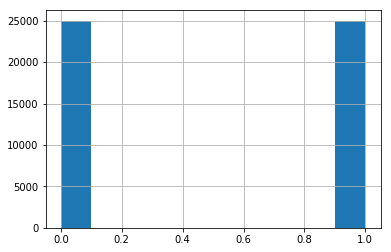

In [76]:
reviews_dataset.sentiment.hist()

In [77]:
reviews_dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 2 columns):
review       50000 non-null object
sentiment    50000 non-null int64
dtypes: int64(1), object(1)
memory usage: 781.3+ KB


In [78]:
reviews_dataset.describe()

,sentiment
count,50000.000000
mean,0.500000
std,0.500005
min,0.000000
25%,0.000000
50%,0.500000
75%,1.000000
max,1.000000


The reviews data set has 50000 reviews, all labeled as positive or negative. There is equal number of positive an negative reviews.

#### Train, validation, test sets

The whole data set is divided into 20% test set (final testing), and 80% training and validation.

In [79]:
from sklearn.model_selection import train_test_split

X_train_val, X_test, y_train_val, y_test = train_test_split(
    reviews_dataset.review, reviews_dataset.sentiment, test_size = 0.2)

In [80]:
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size = 0.25)

### Text processing

Ideas:
I)
1. Get "out of ten" rating from the text.
2. Vectorize the rest.
II) 
1. Investigate adjectives a little bit more. Try to see whether adj is positive or negative and or have negation.

In [81]:
from nltk.tokenize import word_tokenize
import re
import ast

In [82]:
def get_out_of_ten(text):
    pattern1 = re.compile("([0-9.]+)(?:\s)*/(?:\s)*10")
    pattern2 = re.compile("([0-9.]+) out of (?:10|ten)")
    pattern3 = re.compile("(zero|one|two|three|four|five|six|seven|eight|nine|ten) out of (?:10|ten)")
    
    def number_str_to_digit(num_str):
        mapping = {'zero': '0', 'one': '1', 'two': '2', 'three': '3', 'four': '4', 'five': '5', 'six': '6', 'seven': '7', 'eight': '8', 'nine': '9', 'ten': '10'}
        return mapping.get(num_str)
    
    matches = pattern1.findall(text)
    matches.extend(pattern2.findall(text))
    matches.extend([number_str_to_digit(num_str) for num_str in pattern3.findall(text)])
    
    def literal_eval(num_str):
        try:
            return ast.literal_eval(num_str)
        except:
            try:
                return ast.literal_eval(num_str.strip('.').lstrip('0')) 
            except:
                return 5
            
    matches = [literal_eval(num_str) for num_str in matches]
    #matches = [ast.literal_eval(num_str) for num_str in matches]
    return matches

print(get_out_of_ten("Gave it 2/10"))
print(get_out_of_ten("Received 7.5 / 10"))
print(get_out_of_ten("Gave it 11 out of ten"))
print(get_out_of_ten("Gave it 2 out of 10"))
print(get_out_of_ten("Gave it two out of ten"))
print(get_out_of_ten("Gave it ...2/10"))

[2]
[7.5]
[11]
[2]
[2]
[2]


In [83]:
train_out_of_ten = [get_out_of_ten(text) for text in X_train]
val_out_of_ten = [get_out_of_ten(text) for text in X_val]
test_out_of_ten = [get_out_of_ten(text) for text in X_test]

x = 0
for text in X_train:
    out_of_ten = get_out_of_ten(text)
    if len(out_of_ten) > 0 and x < 10:
        print(out_of_ten)
        print(text)
        x += 1

[4]
I love exotic science fiction/fantasy movies but this one was very unpleasant to watch. Suggestions and images of child abuse, mutilated bodies (live or dead), other gruesome scenes, plot holes, boring acting made this a regretable experience, The basic idea of entering another person's mind is not even new to the movies or TV (An Outer Limits episode was better at exploring this idea). i gave it 4/10 since some special effects were nice.
[10]
When it comes to Paul Verhoeven and erotic thrillers, most people think of "Basic Instinct" and some maybe of "Showgirls". But Verhoeven has made his best erotic thriller years before these two movies: "De Vierde Man". This film is mesmerizing and mindblowing - and above all the story is absolutely plausible, which makes the whole experience even more intense. The performances by Jeroen Krabbe, Renee Soutendijk and Thom Hoffman are exceptional, and Verhoeven's direction does the rest. "De Vierde Man" makes even "Basic Instinct" look quite tam

In [84]:
def flatten_rating(rating_table):
    flat = []
    for rating in rating_table:
        flat.append(rating[-1] if len(rating) else None)
    return flat

train_out_of_ten_flat = flatten_rating(train_out_of_ten)
val_out_of_ten_flat = flatten_rating(val_out_of_ten)
test_out_of_ten_flat = flatten_rating(test_out_of_ten)

print(train_out_of_ten_flat)

[None, None, None, None, None, None, 4, None, None, None, None, None, None, 10, 3.5, None, None, 8, None, None, None, None, 10, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, 7, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, 8, None, None, 8, None, 9, None, None, 1, None, None, None, None, 1, None, None, 2, None, 2, None, None, None, 10, None, None, None, None, None, None, None, None, None, None, None, None, None, 1, None, None, None, None, None, None, 10, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, 8, None, 4, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, 1, None, 8, None, None, None, None, 2, 9.1, N

In [85]:
train_rating_set = pd.DataFrame({'rating': train_out_of_ten_flat, 'sentiment': y_train})
val_rating_set = pd.DataFrame({'rating': val_out_of_ten_flat, 'sentiment': y_val})
test_rating_set = pd.DataFrame({'rating': test_out_of_ten_flat, 'sentiment': y_test})

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f506a42e358>,
      dtype=object)

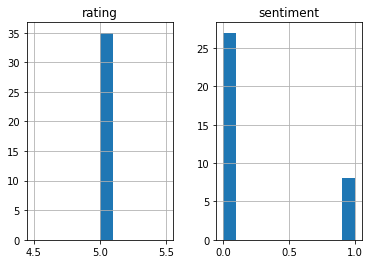

In [86]:
train_rating_set.dropna()[train_rating_set.dropna().rating == 5].hist()

In [87]:
def count_rated(rates):
    rated = 0
    for rate in rates:
        if len(rate):
            rated += 1
    return rated

print(count_rated(train_out_of_ten))
print(count_rated(val_out_of_ten))
print(count_rated(test_out_of_ten))


2747
872
892


In [88]:
import re

delete_br_reg = re.compile("<br \/>")
def delete_br(text):
    return delete_br_reg.sub("", text)

print(delete_br("<br />"))
print(delete_br("<br /><br />Worst. Movie. Ever.<br /><br />What was the purpose of filming this remake (aside from turning it into a 90-minute informercial for the movie's soundtrack)? Zombies that *run*??? I guess the director never watched the original \"Dead\" films, which show stiff-limbed (from rigor mortis) creatures shuffling/shambling toward their living prey.<br /><br />And how, exactly, did the survivors know which boat in the marina belonged to the recently departed Steve?<br /><br />1/10"))


Worst. Movie. Ever.What was the purpose of filming this remake (aside from turning it into a 90-minute informercial for the movie's soundtrack)? Zombies that *run*??? I guess the director never watched the original "Dead" films, which show stiff-limbed (from rigor mortis) creatures shuffling/shambling toward their living prey.And how, exactly, did the survivors know which boat in the marina belonged to the recently departed Steve?1/10


In [89]:
from nltk.tokenize import TweetTokenizer

tknzr = TweetTokenizer()
puntucation = re.compile("[\.,\(\)\[\]\{\}\/\"\*&\^\%\$\#\@\!\?\<\>-]")

def tokenize(text):
    text_no_punctuation = puntucation.sub(" ", text)
    tokenized_text = [word.lower() for word in tknzr.tokenize(text_no_punctuation)]
    tokenized_text = [word for word in tokenized_text if not word.isnumeric()]
    return tokenized_text


tokenize("Worst. Movie. Ever.What was the purpose of filming this remake (aside from turning it into a 90-minute informercial for the movie's soundtrack)? Zombies that *run*??? I guess the director never watched the original \"Dead\" films, which show stiff-limbed (from rigor mortis) creatures shuffling/shambling toward their living prey.And how, exactly, did the survivors know which boat in the marina belonged to the recently departed Steve?1/10")


['worst',
 'movie',
 'ever',
 'what',
 'was',
 'the',
 'purpose',
 'of',
 'filming',
 'this',
 'remake',
 'aside',
 'from',
 'turning',
 'it',
 'into',
 'a',
 'minute',
 'informercial',
 'for',
 'the',
 "movie's",
 'soundtrack',
 'zombies',
 'that',
 'run',
 'i',
 'guess',
 'the',
 'director',
 'never',
 'watched',
 'the',
 'original',
 'dead',
 'films',
 'which',
 'show',
 'stiff',
 'limbed',
 'from',
 'rigor',
 'mortis',
 'creatures',
 'shuffling',
 'shambling',
 'toward',
 'their',
 'living',
 'prey',
 'and',
 'how',
 'exactly',
 'did',
 'the',
 'survivors',
 'know',
 'which',
 'boat',
 'in',
 'the',
 'marina',
 'belonged',
 'to',
 'the',
 'recently',
 'departed',
 'steve']

In [90]:
from nltk.corpus import stopwords
stop_words =  set(stopwords.words('english'))
stop_words

{'a',
 'about',
 'above',
 'after',
 'again',
 'against',
 'ain',
 'all',
 'am',
 'an',
 'and',
 'any',
 'are',
 'aren',
 "aren't",
 'as',
 'at',
 'be',
 'because',
 'been',
 'before',
 'being',
 'below',
 'between',
 'both',
 'but',
 'by',
 'can',
 'couldn',
 "couldn't",
 'd',
 'did',
 'didn',
 "didn't",
 'do',
 'does',
 'doesn',
 "doesn't",
 'doing',
 'don',
 "don't",
 'down',
 'during',
 'each',
 'few',
 'for',
 'from',
 'further',
 'had',
 'hadn',
 "hadn't",
 'has',
 'hasn',
 "hasn't",
 'have',
 'haven',
 "haven't",
 'having',
 'he',
 'her',
 'here',
 'hers',
 'herself',
 'him',
 'himself',
 'his',
 'how',
 'i',
 'if',
 'in',
 'into',
 'is',
 'isn',
 "isn't",
 'it',
 "it's",
 'its',
 'itself',
 'just',
 'll',
 'm',
 'ma',
 'me',
 'mightn',
 "mightn't",
 'more',
 'most',
 'mustn',
 "mustn't",
 'my',
 'myself',
 'needn',
 "needn't",
 'no',
 'nor',
 'not',
 'now',
 'o',
 'of',
 'off',
 'on',
 'once',
 'only',
 'or',
 'other',
 'our',
 'ours',
 'ourselves',
 'out',
 'over',
 'own',
 'r

In [91]:
def remove_unused_symbols(text):    
    # Remove <br />
    text = delete_br(text)
    # Tokenize (remove punktuation and digits)
    text = tokenize(text)
    return text
    

In [92]:
def text_processing(text):
    text = remove_unused_symbols(text)
    
    return [word for word in text if not word in stop_words]

In [93]:
text_processing("I had been looking forward to How to Lose Friends & Alienate People for months, particularly due to the fact that Kirsten Dunst and Simon Pegg were starring. Simon Pegg is a comedic genius and Kirsten Dunst has always been a favorite actress of mine. How to Lose Friends & Alienate People hit the spot! Of course not perfect, but very enjoyable and funny. How to Lose Friends & Alienate People follows the life of Sidney Young, a smalltime, bumbling, British celebrity journalist, who is hired by an upscale magazine in New York City. In spectacular fashion Sidney enters high society and burns bridges with bosses, peers and superstars. After disrupting one black-tie event by allowing a wild pig to run rampant, Sidney catches the attention of Clayton Harding, editor of Sharp, and accepts a job with the magazine in New York City. Clayton warns Sidney that he'd better impress and charm everyone he can, if he wants to succeed. Instead, Sidney instantly insults and annoys fellow writer Alison Olsen (Kirsten Dunst). He dares to target the star clients of power publicist Eleanor Johnson (Gillian Anderson). He also upsets his direct boss Lawrence Maddox (Danny Huston). Sidney finds creative ways to annoy nearly everyone. His saving grace, a rising starlet Sophie Maes (Megan Fox) who develops an odd affection for him. In time, Allison's friendship might be the only thing saving Sydney from his downward spiraling career. The storyline is very interesting and the acting was top notch with what the actors were given. Simon Pegg is still hilarious as ever! He makes Sydney bumbling, obnoxious, and annoying as real as it gets, but later in time making Sydney not just likable, but also a real character who you root for in the end. Kirsten Dunst and Jeff Bridges were brilliant! Kirsten had some very wonderful acting and hilarious scenes, and Jeff Bridges is just Jeff f*cking Bridges! How can you not like him?! He makes Clayton a very humorous character with some wit and overall you just love the guy. Gillian Anderson, Megan Fox, and Danny Huston were great as the supporting cast. Each had their own personality that were overall pretty unlikable, but that's what just made the film work. One thing I didn't enjoy was how one dimensional some of the characters were. I understand that most were the supporting cast, but some of the cast was underused and could've given the film some more spice to it. How to Lose Friends & Alienate People will never be on anyone's top 10 films ever, or even top 10 comedies ever, but it has a very high entertainment level and some scenes may even charm you as well. How to Lose Friends & Alienate People is definitely one of the better romantic comedies of the year! 8/10")

['looking',
 'forward',
 'lose',
 'friends',
 'alienate',
 'people',
 'months',
 'particularly',
 'due',
 'fact',
 'kirsten',
 'dunst',
 'simon',
 'pegg',
 'starring',
 'simon',
 'pegg',
 'comedic',
 'genius',
 'kirsten',
 'dunst',
 'always',
 'favorite',
 'actress',
 'mine',
 'lose',
 'friends',
 'alienate',
 'people',
 'hit',
 'spot',
 'course',
 'perfect',
 'enjoyable',
 'funny',
 'lose',
 'friends',
 'alienate',
 'people',
 'follows',
 'life',
 'sidney',
 'young',
 'smalltime',
 'bumbling',
 'british',
 'celebrity',
 'journalist',
 'hired',
 'upscale',
 'magazine',
 'new',
 'york',
 'city',
 'spectacular',
 'fashion',
 'sidney',
 'enters',
 'high',
 'society',
 'burns',
 'bridges',
 'bosses',
 'peers',
 'superstars',
 'disrupting',
 'one',
 'black',
 'tie',
 'event',
 'allowing',
 'wild',
 'pig',
 'run',
 'rampant',
 'sidney',
 'catches',
 'attention',
 'clayton',
 'harding',
 'editor',
 'sharp',
 'accepts',
 'job',
 'magazine',
 'new',
 'york',
 'city',
 'clayton',
 'warns',
 'sid

### Features preparation

In [94]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf = TfidfVectorizer()

def prepare_features(X_train, X_val, X_test):    
    X_train_vec = tfidf.fit_transform([" ".join(text_processing(x)) for x in X_train])
    X_val_vec = tfidf.transform([" ".join(text_processing(x)) for x in X_val])
    X_test_vec = tfidf.transform([" ".join(text_processing(x)) for x in X_test])
    
    return X_train_vec, X_val_vec, X_test_vec

X_train_set, X_val_set, X_test_set = prepare_features(X_train, X_val, X_test)

## Evaluation

Evaluation:
- accuracy score (as negative and positive is symmetric)
- Confusion matrix (to judge if there is a case that needs more investigation)
- ROC AUC (to judge how well those classes are separated)


In [95]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.metrics import confusion_matrix

def evaluate(y_pred, y_scores, y_true):
    res_accuracy = accuracy_score(y_true, y_pred)
    res_roc_auc_score = roc_auc_score(y_true, y_pred)
    fpr, tpr, thresholds = roc_curve(y_true, y_scores[:, 1])
    
    print("Accuracy: %f, ROC AUC score: %f" % (res_accuracy, res_roc_auc_score))
    
    print(confusion_matrix(y_true, y_pred))

    plt.figure()
    lw = 2
    plt.plot(fpr, tpr, color='darkorange',
             lw=lw, label='ROC curve (area = %0.2f)' % res_roc_auc_score)
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic example')
    plt.legend(loc="lower right")
    plt.show()

## Training

- logistic regression
- random forest
- xgboost
- SVM (?)

In [96]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.svm import SVC

### Rating based classificator

In [97]:
def predict(X):
    return (X > 5).astype(int)    

val_rating_set_no_na = val_rating_set.dropna()
rating_y_pred = predict(val_rating_set_no_na.rating)

print('Accuracy: %f\nConfusion matrix:' % accuracy_score(val_rating_set_no_na.sentiment, rating_y_pred))
print(confusion_matrix(val_rating_set_no_na.sentiment, rating_y_pred))

Accuracy: 0.948394
Confusion matrix:
[[396  29]
 [ 16 431]]


### First round

Accuracy: 0.894000, ROC AUC score: 0.893995
[[4411  587]
 [ 473 4529]]


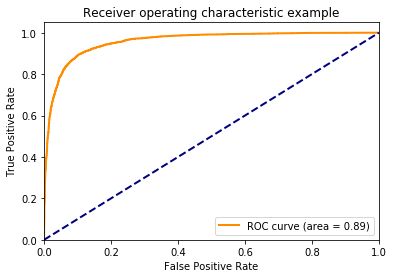

Accuracy: 0.839200, ROC AUC score: 0.839207
[[4285  713]
 [ 895 4107]]


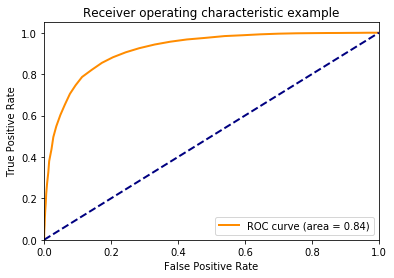

Accuracy: 0.811400, ROC AUC score: 0.811377
[[3764 1234]
 [ 652 4350]]


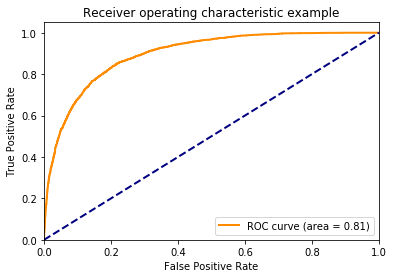

In [ ]:
log_reg = LogisticRegression().fit(X_train_set, y_train)
evaluate(log_reg.predict(X_val_set), log_reg.predict_proba(X_val_set), y_val)

forest = RandomForestClassifier(n_estimators=50, n_jobs=7).fit(X_train_set, y_train)
evaluate(forest.predict(X_val_set), forest.predict_proba(X_val_set), y_val)

gradient_boost = GradientBoostingClassifier().fit(X_train_set, y_train)
evaluate(gradient_boost.predict(X_val_set), gradient_boost.predict_proba(X_val_set), y_val)

#svm = SVC(probability=True).fit(X_train_set, y_train)
#evaluate(svm.predict(X_val_set), svm.predict_proba(X_val_set), y_val)




In [24]:
from sklearn.model_selection import GridSearchCV
import time

print('Logistic regression')
start_time = time.time()
## Logistic regression
log_reg_params = {
    'penalty': ['l1', 'l2'],
    'C': [0.1, 1.0, 10, 100],
    'n_jobs': [7]
}
log_reg_grid = GridSearchCV(LogisticRegression(), log_reg_params).fit(X_train_set, y_train)
print("Grid search score: %f, params: %s" % (log_reg_grid.best_score_, log_reg_grid.best_params_))
print('Logistic regression, completed: %f' % (time.time() - start_time))

print('Random forest')
start_time = time.time()

## Random forest params
forest_params = {
    'n_estimators': [50, 100, 150, 200],
    'max_features': ['auto', 'sqrt', 'log2', None],
    'min_samples_leaf': [1, 10, 50, 100],
    'n_jobs': [7]
}
forest_grid = GridSearchCV(RandomForestClassifier(), forest_params).fit(X_train_set, y_train)

print("Grid search score: %f, params: %s" % (forest_grid.best_score_, forest_grid.best_params_))
print('Random forest, completed: %f' % (time.time() - start_time))


Logistic regression


/home/danka/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 7.
  " = {}.".format(self.n_jobs))
/home/danka/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 7.
  " = {}.".format(self.n_jobs))
/home/danka/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 7.
  " = {}.".format(self.n_jobs))
/home/danka/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 7.
  " = {}.".format(self.n_jobs))
/home/danka/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1228: Use

Grid search score: 0.891967, params: {'C': 10, 'n_jobs': 7, 'penalty': 'l2'}
Logistic regression, completed: 23.347345
Random forest
Grid search score: 0.858367, params: {'max_features': 'sqrt', 'min_samples_leaf': 1, 'n_estimators': 200, 'n_jobs': 7}
Random forest, completed: 14041.629234
Gradient boosting


ValueError: Invalid parameter n_jobs for estimator GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.05, loss='deviance', max_depth=3,
              max_features='auto', max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=50,
              presort='auto', random_state=None, subsample=1.0, verbose=0,
              warm_start=False). Check the list of available parameters with `estimator.get_params().keys()`.

logistic regression
Accuracy: 0.895500, ROC AUC score: 0.895356
[[4352  548]
 [ 497 4603]]


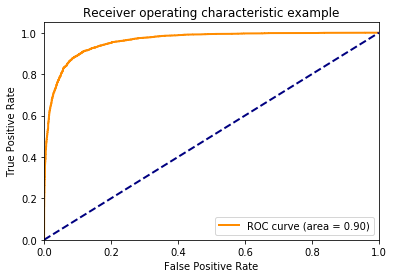

Random Forest
Accuracy: 0.860400, ROC AUC score: 0.860636
[[4275  625]
 [ 771 4329]]


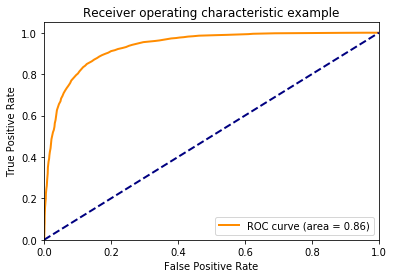

In [98]:
print("logistic regression")
log_reg = LogisticRegression(penalty='l2', C=10).fit(X_train_set, y_train)
evaluate(log_reg.predict(X_val_set), log_reg.predict_proba(X_val_set), y_val)

print("Random Forest")
forest = RandomForestClassifier(n_estimators=200, n_jobs=6, max_features='sqrt', min_samples_leaf=1).fit(X_train_set, y_train)
evaluate(forest.predict(X_val_set), forest.predict_proba(X_val_set), y_val)


### Dimentionalit reduction

In [133]:
from sklearn.decomposition import TruncatedSVD

In [134]:
svd = TruncatedSVD(n_components=100)

In [135]:
X_train_set_svd = svd.fit_transform(X_train_set)
X_val_set_svd = svd.transform(X_val_set)
X_test_set_svd = svd.transform(X_test_set)

logistic regression
Accuracy: 0.865100, ROC AUC score: 0.864904
[[4190  710]
 [ 639 4461]]


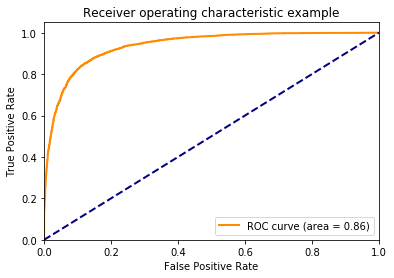

Random Forest
Accuracy: 0.822100, ROC AUC score: 0.822095
[[4027  873]
 [ 906 4194]]


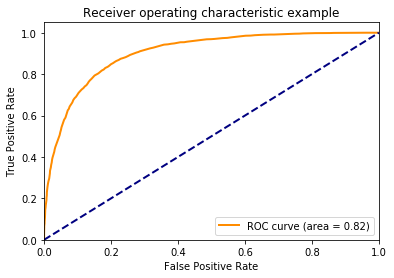

In [136]:
print("logistic regression")
log_reg_2 = LogisticRegression(penalty='l2', C=10).fit(X_train_set_svd, y_train)
evaluate(log_reg_2.predict(X_val_set_svd), log_reg_2.predict_proba(X_val_set_svd), y_val)

print("Random Forest")
forest_2 = RandomForestClassifier(n_estimators=200, n_jobs=6, max_features='sqrt', min_samples_leaf=1).fit(X_train_set_svd, y_train)
evaluate(forest_2.predict(X_val_set_svd), forest_2.predict_proba(X_val_set_svd), y_val)


In [139]:
from sklearn.model_selection import GridSearchCV
import time

print('Logistic regression')
start_time = time.time()
## Logistic regression
log_reg_params = {
    'penalty': ['l1', 'l2'],
    'C': [0.1, 1.0, 10, 100],
    'n_jobs': [7]
}
log_reg_grid_2 = GridSearchCV(LogisticRegression(), log_reg_params).fit(X_train_set_svd, y_train)
print("Grid search score: %f, params: %s" % (log_reg_grid_2.best_score_, log_reg_grid_2.best_params_))
print('Logistic regression, completed: %f' % (time.time() - start_time))

print('Random forest')
start_time = time.time()

## Random forest params
forest_params = {
    'n_estimators': [50, 100, 150, 200],
    'max_features': ['auto', 'sqrt', 'log2', None],
    'min_samples_leaf': [1, 10, 50, 100],
    'n_jobs': [7]
}
forest_grid_2 = GridSearchCV(RandomForestClassifier(), forest_params).fit(X_train_set_svd, y_train)

print("Grid search score: %f, params: %s" % (forest_grid_2.best_score_, forest_grid_2.best_params_))
print('Random forest, completed: %f' % (time.time() - start_time))


Logistic regression


/home/danka/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 7.
  " = {}.".format(self.n_jobs))
/home/danka/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 7.
  " = {}.".format(self.n_jobs))
/home/danka/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 7.
  " = {}.".format(self.n_jobs))
/home/danka/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 7.
  " = {}.".format(self.n_jobs))
/home/danka/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1228: Use

Grid search score: 0.862500, params: {'C': 10, 'n_jobs': 7, 'penalty': 'l2'}
Logistic regression, completed: 10.905367
Random forest
Grid search score: 0.820833, params: {'max_features': 'sqrt', 'min_samples_leaf': 1, 'n_estimators': 200, 'n_jobs': 7}
Random forest, completed: 2616.758279
